Blankenbach Benchmark Case 1
======

Steady isoviscous convection
----

This is a benchmark case of two-dimensional, incompressible, bottom heated, steady isoviscous thermal convection. This example is based on case 1 in Blankenbach *et al.* 1989 for a single Rayleigh number.

**This lesson introduces the concepts of:**
1. Loading/Saving variables to disk.
2. Defining analysis tools for use in the time loop.
3. The main simulation time loop.
4. Finding a steady state.
5. Plotting physical quantities on the mesh.
6. Writing tools for post simulation data analysis.

**Keywords:** Stokes system, advective diffusive systems, analysis tools, tools for post analysis


**References**

1. B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract


In [1]:
%matplotlib inline
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set simulation parameters for test.

In [2]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
tempMin = 0.0
tempMax = 1.0
# Set the resolution.
res = 128

Choose which case from Blankenbach paper, or set values manually

In [3]:
case = 'a' # 'a', 'b' or 'c'
if(case=='c'):
    Ra=1.e6
    eta0=1.e21
elif(case=='b'):
    Ra=1.e5
    eta0=1.e22
else: # case a and default
    Ra=1.e4
    eta0=1.e23

**Set physical values in SI units**

In [4]:
rho  = 4.0e3
grav = 10
height = 1.e6
kappa  = 1.0e-6

**Input/output paths**


Set input and output file directory paths

In [5]:
inputPath  = 'BBInput/'
outputPath = 'BBOutput/'
# Make output directory if necessary.
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

Create mesh and finite element variables
------

In [6]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField    = uw.fevariable.FeVariable( feMesh=mesh, nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=mesh.subMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=mesh, nodeDofCount=1 )
temperatureDotField = uw.fevariable.FeVariable( feMesh=mesh, nodeDofCount=1 )

Set up material parameters and functions
-----

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 


In [7]:
# Set a constant viscosity.
viscosity = 1.

# Create our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# A buoyancy function.
buoyancyFn = densityFn * z_hat

# The temperature gradient is useful in the analysis below. We access it via the 'gradientFn' attribute provided
# via the FeVariable.
gradField = temperatureField.gradientFn

Set initial conditions and boundary conditions
----------

**Initial conditions**

Either set by rough function or load data from file.

In [8]:
LoadFromFile = True

Common for both loading and initialising

In [9]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureDotField.data[:] = 0.

**If loading from file**

Read 64\*64 data stored as a ``numpy`` array from ``numpy`` formatted binary file. Have saved data files for 3 values of Rayleigh number. Will use the closest of $Ra = 10^4$, $10^5$ or $10^6$. Once loaded the data will need to be re-meshed onto a new grid, unless the new resolution is also 64\*64.

For more information on using meshes see the user guide.


In [10]:
if(LoadFromFile == True):
# Setup mesh for 64*64 data file.
    mesh64 = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                       elementRes  = (64, 64), 
                                       minCoord    = (0., 0.), 
                                       maxCoord    = (boxLength, boxHeight))
    temperatureField64  = uw.fevariable.FeVariable( feMesh=mesh64, nodeDofCount=1 )
# Determine which stored Ra number is closest.
    logRa=int(math.log10(Ra))
    if(logRa<4):
        logRa=4
    if(logRa>6):
        logRa=6
    if(logRa == 4):
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e4.h5')
        print('Loading 64*64 for Ra = 1e4')
    elif(logRa == 6):
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e6.h5')
        print('Loading 64*64 for Ra = 1e6')
    else:
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e5.h5')
        print('Loading 64*64 for Ra = 1e5')
    if(res==64): # no remeshing needed, copy directly
        temperatureField.data[:] = temperatureField64.data[:]
    else: # remeshing needed
        temperatureField.data[:] = temperatureField64.evaluate(mesh)

Loading 64*64 for Ra = 1e4


**If _not_ loading from file: Initialise data**

Start with a perturbed temperature gradient to speed up the convergence to the benchmark steady state solution. Note that we are also changing the boundary values here.

In [11]:
if(LoadFromFile == False):
    temperatureField.data[:] = 0.
    pertStrength = 0.1
    deltaTemp = tempMax - tempMin
    for index, coord in enumerate(mesh.data):
        pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
        temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
        temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [12]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [13]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               nodeIndexSets = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               nodeIndexSets = (jWalls,) )

**Plot initial conditions for temperature**


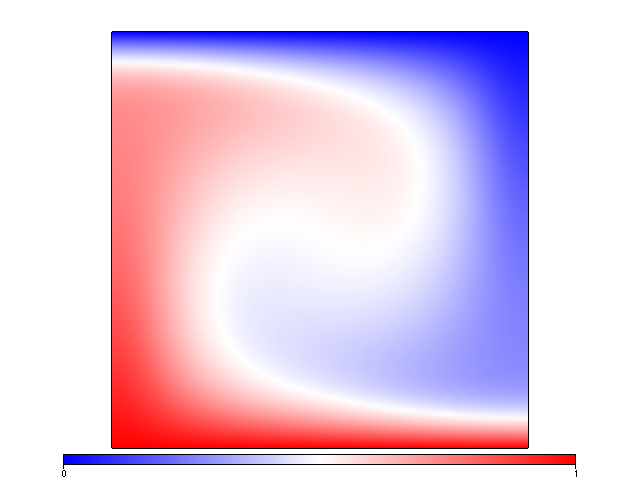

In [14]:
figtemp = glucifer.Figure()
figtemp + glucifer.objects.Surface( mesh, temperatureField, colours="blue white red" )
figtemp.show()

System setup
-----

**Setup a Stokes system**


In [15]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosity, 
                               bodyForceFn   = buoyancyFn )

**Create an advective diffusive system**


In [16]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField, diffusivity=1., conditions=[tempBC,], )

Analysis tools
-----

**Nusselt number**


The Nusselt number is the ratio between convective and conductive heat transfer and can be calculated by the following integral
\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]





The following function evaluates the vertical (z) component [1] of the gradient function of the temperature field at the top boundary. The function is called in the main time loop below.

In [17]:
def FindNusseltNumber(temperatureField, mesh, xmax, zmax):
    tempgradField = temperatureField.gradientFn
    vertGradField = tempgradField[1]
    bottomInt = 0.0
    gradValues = temperatureField.gradientFn[1].evaluate(mesh.specialSets["MaxJ_VertexSet"])
    topInt = sum(gradValues)
    for index in mesh.specialSets["MinJ_VertexSet"]:
        bottomInt += temperatureField.data[index]
    nu = -zmax*topInt/bottomInt
    return nu[0]

This function is used to determine the initial Nusselt number in the following way

In [18]:
nu = FindNusseltNumber(temperatureField, mesh, boxLength, boxHeight)
print('Initial Nusselt number = {0:.3f}'.format(nu))

Initial Nusselt number = 4.853


**Evaluate function**


The function defined above used the evaluate function which is a useful function built into underworld. When applied to the following structures, it allows:
1. FeVariables: liner interpolation at a specified point
2. other functions: evaluate the function at a point where possible

For more information see the 

**RMS velocity**

For comparison with the Blankenbach benchmark results the non-dimensional, root mean squared velocity is used. This is defined by intergrating over the entire simulation domain via
\\[
\begin{aligned}
v_{rms} & = \frac{h}{\kappa} \left[ \frac{1}{hl} \int_0^l \int_0^h (u^2 + w^2) dz dx  \right]^{1/2} \\
 & =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]
where $V$ denotes the entire 'volume' of the box, which is the x, z surface for a 2D simulation.

This can be setup in underworld by defining the following functions as integrals of other functions. Here v2sum_integral is defined as the integral over the entire mesh of the function which is $\mathbf{v}.\mathbf{v}$. This is used in the main time loop to calculate statistics and compare to the benchmark results when the system is in steady-state.

In [19]:
vdotv = fn.math.dot( velocityField, velocityField )
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

Main simulation loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

*If loading from a file* then a quick number of steps are taken to compare to known benchmark values for the underworld code.

In [20]:
time = 0.
step = 0
if(LoadFromFile == True):
    steps_end = 1
else:
    steps_end = 5000
steps_output = min(100, steps_end/10)
steps_output = max(steps_output, 1)
timeVal = []
vrmsVal = []
nuLast     = -1.0
iloop      = True
epsilon    = 1.e-8
velplotmax = 0.0

Next the time steps are carried out until the maximum number of steps is reached, or until the relative change in the Nusselt number is less than the criteria value (epsilon). 

**The time loop consists of:**
1. Solving the Stokes system.
2. Determining the maximum timestep (dt) for advancing the advection-diffusion system.
3. Calculating new velocities by integrating the advection-diffusion system with the maximum timestep.
4. Calculate and store the statistical quantities ($v_{rms}$ and $Nu$).
5. Check that the Nusselt number is still changing sufficiently to require another loop.
6. Increment number of time steps and the time and loop again.

In [21]:
# Perform steps.
while iloop == True:
    # Get solution for initial configuration.
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size. 
    advDiff.integrate(dt)
    # Calculate the RMS velocity and Nusselt number.
    v2sum  = v2sum_integral.evaluate()
    volume = volume_integral.evaluate()
    rms_v = math.sqrt( v2sum[0] )/volume[0]
    nu    = FindNusseltNumber( temperatureField, mesh, boxLength, boxHeight )
    # Store v_rms and time.
    vrmsVal.append(rms_v)
    timeVal.append(time)
    velplotmax = max(rms_v, velplotmax)
    # Check loop break condition.
    if(abs((nu - nuLast)/nu) < epsilon):
        iloop = False
        print('steps = {0:6d}; time = {1:.3e}; v_rms = {2:.3f}; Nu = {3:.3f}; Rel change = {4:.3e}'
          .format(step, time, rms_v, nu, abs((nu - nuLast)/nu)))
    if step%(steps_end/steps_output) == 0:
        print('steps = {0:6d}; time = {1:.3e}; v_rms = {2:.3f}; Nu = {3:.3f}; Rel change = {4:.3e}'
          .format(step, time, rms_v, nu, abs((nu - nuLast)/nu)))
    if step>=steps_end:
        iloop = False
    # Increment time and timestep counter and save previous Nusselt number
    time += dt
    step += 1
    nuLast = nu

steps =      0; time = 0.000e+00; v_rms = 42.868; Nu = 4.853; Rel change = 1.206e+00
steps =      1; time = 0.000e+00; v_rms = 42.869; Nu = 4.862; Rel change = 2.023e-03


If the initial conditions are loaded from file then this loop will only take a single step, since the saved data is already in steady state. If you would like to run the entire simulation from a small perturbation then change the ``LoadFromFile`` variable above to equal ``False``. Warning: the simulation will take a long time to get to steady state.

Post simulation analysis
-----

**Benchmark values**

The time loop above outputs $v_{rms}$ and $Nu$ as general statistics for the system. For comparison, the benchmark values for the RMS velocity and Nusselt number are shown below for different Rayleigh numbers. All benchmark values shown below were determined in Blankenbach *et al.* 1989 by extroplation of numerical results. 


| $Ra$          | $v_{rms}$   | $Nu$  |   $q_1$  | $q_2$  |
| ------------- |:-------------:|:-----:|:-----:|:-----:|
| 10$^4$ | 42.865 |  4.884 | 8.059 | 0.589 |
| 10$^5$ | 193.215 | 10.535 | 19.079 | 0.723 |
| 10$^6$ | 833.990 | 21.972 | 45.964 | 0.877 |


For practicality, quick tests can be run to see that the results are close enough. Tests run using underworld gave

| $Ra$          | $v_{rms}$   | $Nu$  |
| ------------- |:-------------:|:-----:|
| 10$^4$ | 42.858 |  4.848 |
| 10$^5$ | 193.449 | 10.248 |
| 10$^6$ | 844.218 | 19.660 |


**Resulting pressure field**

Use the same method as above to plot the new temperature field. This can also be used to plot the pressure field, or any other data structures of interest.


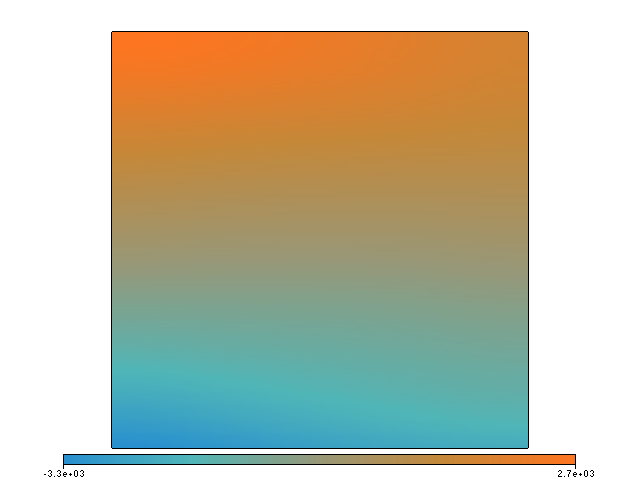

In [22]:
figtemp = glucifer.Figure()
figtemp + glucifer.objects.Surface( mesh, pressureField )
figtemp.show()

**Save temperature data**

Save the temperature field data to two file using HDF5 format - the default in underworld. This is the same file type as is loaded above.

In [23]:
temperatureField.save(outputPath+'tempfield.h5')

**Plot the velocity vector field**

For this example the velocity field is interesting to see. This is visualised in two ways, firstly plotting a surface colour map of the velocity magnitude, and secondly the velocity vectors at points on the mesh. For aesthetics the vector arrows are scaled by a little more than the maximum $v_{rms}$ value found in the time loop above.


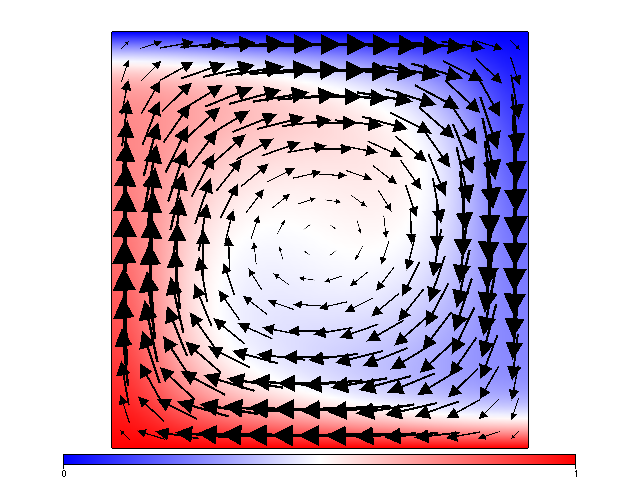

In [24]:
fig2 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2+ glucifer.objects.VectorArrows( mesh, velocityField/(2.5*velplotmax), arrowHeadSize=0.2, lengthScale=0.1 )
fig2+ glucifer.objects.Surface( mesh, temperatureField, colours="blue white red" )
fig2.show()

**Temperature gradient**

The final benchmarks in the Blankenbach paper involve the temperature gradient in the vertical direction ($\frac{\partial T}{\partial z}$). This is easy to find using the underworld functions, as shown below.



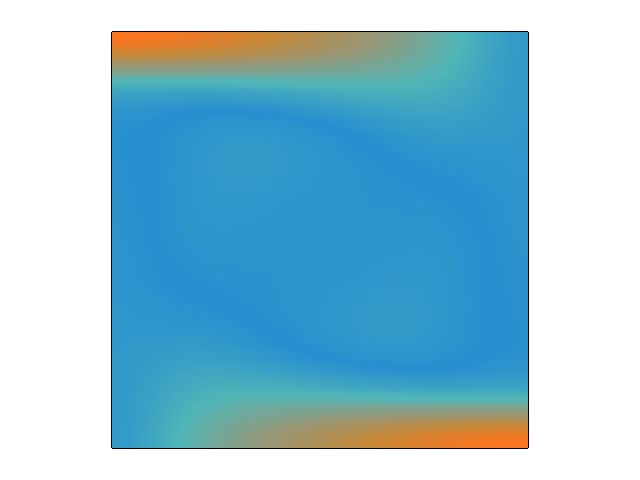

In [25]:
tempgradField = temperatureField.gradientFn
vertTGradField = - boxHeight * tempgradField[1] / tempMax # scaled for direct benchmarking below
fig3 = glucifer.Figure()
vertTGradmagField = uw.function.math.sqrt( uw.function.math.dot( vertTGradField, vertTGradField ) )
fig3 + glucifer.objects.Surface( mesh, vertTGradmagField, colourBar = False )
fig3.show()

**More benchmark values**


The vertical temperature gradient (above) is set up to be non-dimensional as per Blankenbach et al 1989. To compare to the benchmark values in their work the gradient is compared at the corners of the simulation box: $q_1$ at $x = 0$, $z = h$; $q_2$ at $x = l$, $z = h$; $q_3$ at $x = l$, $z = 0$; $q_4$ at $x = 0$, $z = 0$. Where $h$ = Box_Height and $l$ = Box_Length and the non-dimensional gradient field is given by
\\[
q = \frac{-h}{\Delta T} \left( \frac{\partial T}{\partial z} \right)
\\]

Provided the simulation is run to steady-state with sufficent resolution then the $q$ values should be close to the benchmark values given again below for different Rayleigh numbers.

| $Ra$          |    $q_1$  | $q_2$  |
| ------------- |:-----:|:-----:|
| 10$^4$ | 8.059 | 0.589 |
| 10$^5$ | 19.079 | 0.723 |
| 10$^6$ | 45.964 | 0.877 |

The underworld values for $128\times128$ close to convergence are

| $Ra$          |    $q_1$  | $q_2$  |
| ------------- |:-----:|:-----:|
| 10$^4$ | 8.020 | 0.589 |
| 10$^5$ | 18.409 | 0.719 |
| 10$^6$ | 36.769 | 0.831 |


In [26]:
q1 = vertTGradField.evaluate( (0., boxHeight))[0][0]
q2 = vertTGradField.evaluate( (boxLength, boxHeight))[0][0]
q3 = vertTGradField.evaluate( (boxLength, 0.))[0][0]
q4 = vertTGradField.evaluate( (0., 0.))[0][0]

print('Rayleigh number = {0:.1e}'.format(Ra))
print('q1 = {0:.3f}; q2 = {1:.3f}'.format(q1,q2))
print('q3 = {0:.3f}; q4 = {1:.3f}'.format(q3,q4))

Rayleigh number = 1.0e+04
q1 = 8.020; q2 = 0.589
q3 = 8.020; q4 = 0.589


**Save time and rms values**

The following command uses the ``numpy`` package save to text file function to output all $v_{RMS}$ values as a function of time. This is particularly useful if you have run the simulation from the perturbed initial condition rather than the saved data file, as you can see the system coming to steady state.

The format for this text file is:

    timeVal[0], vrmsVal[0]
    timeVal[1], vrmsVal[1]
    ...
    timeVal[N], vrmsVal[N]

In [27]:
np.savetxt(outputPath+'vrms.txt', np.c_[timeVal, vrmsVal], header="Time, VRMS" )

**Calculate stress values for benchmark comparison**


Determine stress field for whole box in dimensionless units (King 2009)
\begin{equation}
\tau_{ij} = \eta \frac{1}{2} \left[ \frac{\partial v_j}{\partial x_i} + \frac{\partial v_i}{\partial x_j}\right]
\end{equation}
which for vertical normal stress becomes
\begin{equation}
\tau_{zz} = \eta \frac{1}{2} \left[ \frac{\partial v_z}{\partial z} + \frac{\partial v_z}{\partial z}\right] = \eta \frac{\partial v_z}{\partial z}
\end{equation}
which is implemented for the whole box in the functions defined below.

In [28]:
# get topography
stresstensorFn    =  2.* stokesPIC.viscosityFn*fn.tensor.symmetric( velocityField.gradientFn ) - pressureField
verticalStressFn  = stresstensorFn[1]
stress_zz_top     = -verticalStressFn.evaluate(mesh.specialSets["MaxJ_VertexSet"])

# subtract the average value for benchmark.
mean_sigma_zz_top = np.mean(stress_zz_top)
sigma_zz_top      = stress_zz_top - mean_sigma_zz_top

Dimensionalise the stress from the vertical normal stress at the top of the box (King 2009)

$$
    \sigma_{t} = \frac{\eta_0 \kappa}{\rho g h^2}\tau _{zz} \left( x, z=h\right)
$$

where all constants have been defined above. Finally calculate the topography, defined using $h = \sigma_{top} / (\rho g)$.

In [29]:
# dimensionalise 
dim_sigma_zz_top  = (eta0 * kappa / (height*height)) * sigma_zz_top

# find topography in [m]
topography        = dim_sigma_zz_top / (rho * grav) 

**Calculate x-coordinate at zero stress**

Calculate the zero point for the stress along the x-axis at the top of the box using the **interpolation function** from ``numpy``. Note that ``numpy`` requires that the first array input for ``np.interp`` must be increasing, so the negative of the topography is used.

In [30]:
xCoordFn = fn.input()[0]
x = xCoordFn.evaluate(mesh.specialSets["MinJ_VertexSet"])
xIntercept = np.interp(0.0,-1.0*topography[:, 0],x[:, 0])

**Topography comparison**

Topography of the top boundary calculated in the left and right corners as given in Table 9 of Blankenbach et al 1989.

| $Ra$          |    $\xi_1$  | $\xi_2$  |  $x$ ($\xi = 0$) |
| ------------- |:-----------:|:--------:|:--------------:|
| 10$^4$  | 2254.02   | -2903.23  | 0.539372          |
| 10$^5$  | 1460.99   | -2004.20  | 0.529330          |
| 10$^6$  | 931.96   | -1283.80  | 0.506490          |

Underworld values for an "almost" converged $128\times128$ benchmark run

| $Ra$          |    $\xi_1$  | $\xi_2$  |  $x$ ($\xi = 0$) |
| ------------- |:-----------:|:--------:|:--------------:|
| 10$^4$  | 2243.93   | -2909.12  | 0.540373          |
| 10$^5$  | 1451.52   | -2005.83  | 0.530246          |
| 10$^6$  | 911.30    | -1282.47  | 0.509696          |


In [31]:
print('Rayleigh number = {0:.1e}'.format(Ra))
print('Topography[x=0],[x=max] = {0:.2f}, {1:.2f}'.format(float(topography[0]),float(topography[len(topography)-1])))
print('x(topo=0) = {0:.6f}'.format(xIntercept))

Rayleigh number = 1.0e+04
Topography[x=0],[x=max] = 2243.93, -2909.12
x(topo=0) = 0.540373
